# Efficiently Representing Faces

##### (Notebook By Itay Hazan)

In [7]:
import re
import numpy
import matplotlib.pyplot as plt

In this exercise, we will try to reduce the dimension of a dataset of black-and-white images of faces.
The `BioID-FaceDatabase` dataset consists of 1521 gray level images with a resolution of 286x384 pixels. Each one shows the frontal view of a face of one out of 23 different test persons. The images are labeled "BioID_xxxx.pgm" where the characters xxxx are replaced by the index of the current image (with leading zeros). Similar to this, the files "BioID_xxxx.eye" contain the eye positions for the corresponding images. We will not be using the eye positions in this exercise.

For your convenience, the code below reads a `pgm` image into a numpy array.

In [2]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

An example of reading and displaying the images is shown below:

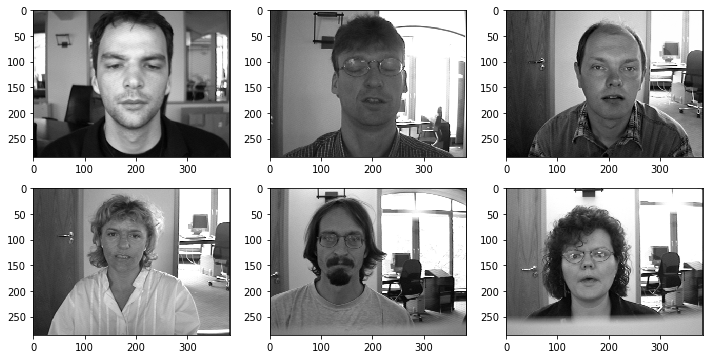

In [12]:
f, axarr = plt.subplots(2,3, figsize=(12, 6))
axarr[0,0].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0000.pgm"), pyplot.cm.gray)
axarr[0,1].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0100.pgm"), pyplot.cm.gray)
axarr[0,2].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0200.pgm"), pyplot.cm.gray)
axarr[1,0].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0300.pgm"), pyplot.cm.gray)
axarr[1,1].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0400.pgm"), pyplot.cm.gray)
axarr[1,2].imshow(read_pgm("BioID-FaceDatabase-V1.2/BioID_0500.pgm"), pyplot.cm.gray)

plt.show()

## Step 1: Read all the images into a numpy array

Read the images into a numpy array, where each image is a `(width x height)` row. 

In [16]:
def read_images(num_images=1521, image_width=384, image_height=286):
    X = np.zeros(image_width*image_height, num_images)
    # read the images
    return X

Display the first 10 images:

In [15]:
# TODO: view first 10 images

## Step 2: Extract Principle Components

Use `sklearn`'s implementation of `PCA` to find $k=50$ principle components of the images.

In [ ]:
k = 50
pca = 

Display the first 10 principle components (columns of the resulting matrix):

Use the `inverse_transform` method to represent the original data in the basis of the extracted $k$ principle components: 

In [ ]:
compressed_X = 

Display the first 5 original images (first 5 rows of X) next to their compressed counterparts (first 5 rows of compressed_X):

Define a matrix `se` to represent the squared error between the original images and the compressed ones, that is: `se` will be a matrix with the same shape as `X` and `compressed_X`, and `se[i,j] = (X[i,j]-compressed_X[i,j])**2` for each entry `(i,j)`.

In [20]:
se = 

Draw a heat map that shows the error in each pixel of the first image (that is, draw a heatmap of `se[0,:]`). 

## Step 3: Try Other Values of $k$ 

Repeat step 2 with other values of $k$, and evaluate the results.